# Two-phase Navier-Stokes with surface tension

Let's consider the incompressible Navier-Stokes equations with two immiscible phases and surface tension.

A domain $\Omega \subset \mathbb{R}^2$ is assumed to be separeted into two phases $\Omega_i(t), i=1,2,$ by a sharp interface $\Gamma(t)$.

Find $(u, p)$ and $\Gamma(t)$ s.t.
\begin{align}
\renewcommand{\jump}[1]{[\mskip-5mu[ #1 ]\mskip-5mu]}
\end{align}
\begin{align}
\rho u_t + \nabla \cdot (\rho u \otimes u) + \nabla \cdot T(u, p) &= \rho g, &\qquad &\text{in } \Omega_i(t), \quad &i&=1,2,\\
\nabla \cdot u &= 0, &\qquad &\text{in } \Omega_i(t), \quad &i&=1,2,\\
\jump{ T(u, p) } n &= \sigma \kappa \cdot n, &\qquad &\text{on } \Gamma(t),\\
\jump{u} &= 0, &\qquad &\text{on } \Gamma(t),\\
\dot x &= u, &\qquad &x \in \Gamma(t),\\
u(0) &= u_0, &\qquad &\text{in } \Omega_i(0), \quad &i&=1,2,\\
\Gamma(0) &= \Gamma_0.
\end{align}

Here, $T(u, p) := p I - \mu (\nabla u + (\nabla u)^T))$ is the stress tensor, $\mu_i, i=1,2,$ are the dynamic viscositities and $\rho_i, i=1,2,$ the densities of the two phases, $g$ is the gravity, $\sigma$ is the surface tension and $\kappa$ is the signed mean curvature of the interface times its normal.

Now, we use Dune-MMesh to compute the result of a rising bubble. Let us consider the [circle](grids/circle.rst) grid.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh, trace, skeleton, domainMarker
from dune.fem.view import adaptiveLeafGridView as adaptive

dim = 2
file = "grids/circle.msh"

gridView = adaptive( mmesh((reader.gmsh, file), dim) )
hgrid = gridView.hierarchicalGrid
igridView = adaptive( hgrid.interfaceGrid )

In [2]:
from ufl import *
from dune.ufl import Constant

mu0   = Constant( 0.5, name="mu0")
mu1   = Constant(   1, name="mu1")
rho0  = Constant( 1.5, name="rho0")
rho1  = Constant(   1, name="rho1")
sigma = Constant(1e-3, name="sigma")
g_y   = Constant(  10, name="g_y")
g     = as_vector([0, -g_y])

dt = 0.1
T  = 0.2

In [3]:
from dune.mmesh import domainMarker

dm = domainMarker(gridView)
mu  = (1-dm) * mu0  + dm * mu1
rho = (1-dm) * rho0 + dm * rho1

In [4]:
from dune.fem.space import dglagrange, combined

uspace = dglagrange(gridView, dimRange=2, order=2)
pspace = dglagrange(gridView, dimRange=1, order=1)
space = combined(uspace, pspace)

trial = TrialFunction(space)
test  = TestFunction(space)

ux,  uy,  p = split(trial)
uux, uuy, q = split(test)

u = as_vector([ux,  uy ])
v = as_vector([uux, uuy])

sol = space.interpolate([0,0,0], name="solution")
solOld = space.interpolate([0,0,0], name="solOld")

## Curvature

The mean curvature $\kappa$ of the interface times its normal can be computed by solving
\begin{align*}
\int_{\Gamma} \kappa \cdot \phi + \nabla x \cdot \nabla \phi \ dS = 0, &\qquad &\text{in } \Gamma(t).\\
\end{align*}

In [5]:
from dune.fem.space import lagrange
from dune.fem.scheme import galerkin

kspace = lagrange(igridView, dimRange=dim, order=1)
k  = TrialFunction(kspace)
kk = TestFunction(kspace)

curvature = kspace.interpolate([0]*dim, name="curvature")

ix = SpatialCoordinate(kspace)
C  = inner(k, kk) * dx
C -= inner(grad(ix), grad(kk)) * dx
kscheme = galerkin([C == 0])
res = kscheme.solve(curvature)

## Navier-Stokes equations

Denoting $(u,v) := \int_\Omega u v dx$ we simply solve
\begin{align}
\renewcommand{\jump}[1]{[\mskip-5mu[ #1 ]\mskip-5mu]}
\renewcommand{\avg}[1]{\{\mskip-5mu\{ #1 \}\mskip-5mu\}}
\end{align}
\begin{align}
(\rho (u^n_h - u^{n-1}_h), v) / \tau + (\nabla \cdot (\rho u^n_h \otimes u^n_h), v) - (T(u^n_h, p^n_h), \nabla v) + (\nabla \cdot u, q ) + \int_\Gamma \sigma \kappa \cdot \avg{v} = (\rho g, v)
\end{align}

and add the necessary terms for the DG discretization.

In [6]:
from dune.mmesh import skeleton
from dune.fem.scheme import galerkin
from dune.ufl import Constant, DirichletBC

x = SpatialCoordinate(space)
n = FacetNormal(space)
h = FacetArea(space)

ispace = dglagrange(igridView, order=0)
chi = ispace.interpolate(0, name="chi")
I = avg(skeleton(chi))

uBC = as_vector([0,0])

tau  = Constant(dt, name="tau")
penu = Constant(1e2, name="penaltyu")
penp = Constant(1e2, name="penaltyp")

uh = as_vector([sol[0], sol[1]])

stress = p * Identity(2) - mu * (grad(u) + grad(u).T)

# Navier-Stokes equations
a  = rho * inner(u - uh, v) / tau * dx
a += inner(div(outer(rho * u, u)), v) * dx
a -= inner(stress, grad(v)) * dx
a += inner(div(u), q) * dx

b = inner(rho * g, v) * dx

# continuity and boundary conditions
a += penu / h * inner(jump(u), jump(v)) * dS
a += penu / h * inner(u - uBC, v) * ds
a += penp / h * jump(p) * jump(q) * (1-I)*dS

# consistency terms
stress2 = - mu * (grad(u) + grad(u).T)
a += dot(dot(avg(stress2), n('+')), jump(v)) * dS
a += dot(dot(stress2, n), v) * ds

# surface tension adds jump in p at the interface 
kappa = avg(skeleton(curvature))
a += dot(sigma * kappa, avg(v)) * I*dS

A = galerkin([a == b], solver=('suitesparse', 'umfpack'))

## Moving

We can obtain the interface movement from the trace of the bulk velocity $u$.

In [7]:
import numpy as np

def getShifts():
    mapper = gridView.hierarchicalGrid.leafView.indexSet
    shifts = np.zeros((gridView.size(dim), dim))
    for e in gridView.elements:
        for v in e.subEntities(dim):
            x = e.geometry.toLocal(v.geometry.center)
            u = sol(e, x)
            shifts[ mapper.index(v) ] = [1,0] #[u[0], u[1]]
    return shifts

def h(u, n):
    sgn = inner(uh('+'), n('+'))
    return conditional( sgn < 0, sgn * u('+'), sgn * u('-') )

detPsi = abs(det(nabla_grad(x + tau * uh)))

am = inner(trial * detPsi - solOld, test) * dx
am += tau * inner(outer(trial, uh), grad(test)) * dx
am -= tau * inner(h(trial, n), jump(test)) * dS

Am = galerkin([am == 0], solver=('suitesparse', 'umfpack'))

## Timeloop

CPU times: user 7.75 s, sys: 2.38 s, total: 10.1 s
Wall time: 7.8 s


/Users/samuelburbulla/dev-env/lib/python3.9/site-packages/matplotlib/quiver.py:678: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/samuelburbulla/dev-env/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


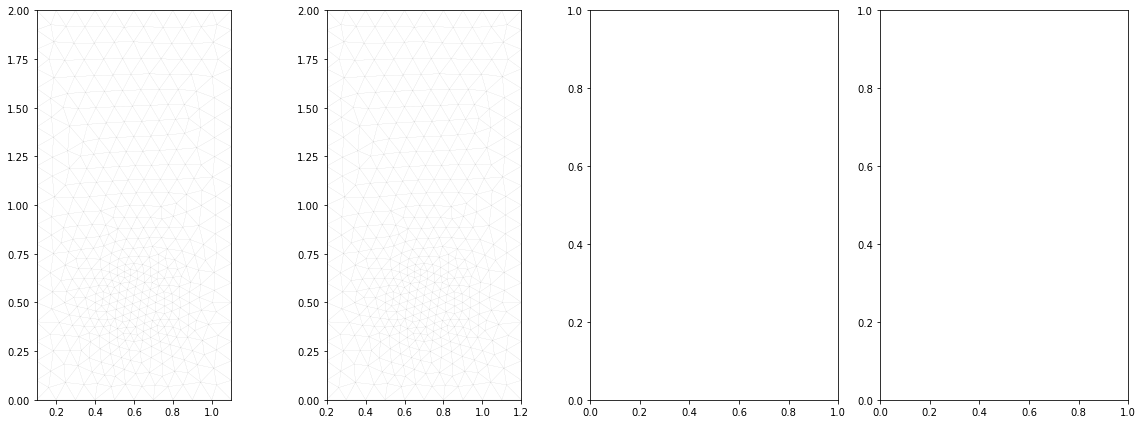

In [8]:
%%time
from dune.fem import parameter, adapt
parameter.append( { "fem.adaptation.method": "callback" } )
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as plt

N = 4
i = 0
fig, axs = plt.subplots(1, N, figsize=(16,6))

sol.interpolate([0,0,0])
solOld.interpolate([0,0,0])

step = 0
t = 0
while t < T+dt:
    kscheme.solve(curvature)
    A.solve(target=sol)

    gridView.writeVTK("twophase-"+str(step), pointdata={"ph": sol[2], "uh": uh},
                      celldata=[dm], nonconforming=True)
    igridView.writeVTK("interface-"+str(step), pointdata=[curvature])
    step += 1
    if int(N * t/T) > i:
        plot(sol[2], figure=(fig, axs[i]), gridLines='black', linewidth=0.02, colorbar=None)
        plot(sol, figure=(fig, axs[i]), gridLines=None, vectors=[0,1])
        i += 1
        
    hgrid.markElements()
    adapt([sol, solOld, dm])
    adapt([curvature, chi])

    sol.interpolate([sol[0], sol[1], 0])
    solOld.assign(sol)
    Am.solve(target=sol)
    solOld.assign(sol)
    hgrid.moveVertices( dt*getShifts() )
    
    t += dt